In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import Dataset

from field_index import FieldIndex
from seismic_batch import SeismicBatch
from utils import get_file_by_index

In [2]:
dfr = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_R_utm.txt', sep='\s+', header=None)
dfr.columns = ['rline', 'rid', 'x', 'y', 'z']
dfr = dfr.astype({'rline': '|S8', 'rid': np.int32, 'x': np.float32, 'y': np.float32, 'z': np.float32})

dfs = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_S_utm.txt', sep='\s+', header=None)
dfs.columns = ['sline', 'sid', 'point_index', 'sht_depth', 'uphole', 'x', 'y', 'z']
dfs = dfs.dropna(axis=0)
dfs = dfs.astype({'sline': '|S8', 'sid': np.int32,
                  'point_index': np.int8, 'sht_depth': np.float32, 'uphole': np.float32,
                  'x': np.float32, 'y': np.float32, 'z': np.float32})

dfx = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_X.sps',
                  sep='\s+', header=None, skiprows=49)
dfx.columns = ['tape', 'xid', 'sline', 'sid', 'from_channel', 'to_channel', 'rline',
               'from_receiver', 'to_receiver']
dfx['sline'] = dfx['sline'].apply(lambda x: "S" + str(x))
dfx['rline'] = dfx['rline'].apply(lambda x: "R" + str(x))
dfx = dfx.astype({'tape': '|S8', 'xid': np.int32, 'sline': '|S8', 'sid': np.int32,
                  'from_channel': np.int16, 'to_channel': np.int16, 'rline': '|S8',
                  'from_receiver': np.int32, 'to_receiver': np.int32})

## Генерация батчей ОПВ сейсмограмм

In [3]:
shot_index = FieldIndex(dfr=dfr, dfs=dfs, dfx=dfx)

In [4]:
shot_set = Dataset(shot_index, SeismicBatch)

In [5]:
shot_batch = shot_set.next_batch(300)

In [6]:
shot_batch.indices[:3]

Index(['b'S1'/1011', 'b'S1'/1031', 'b'S1'/1051'], dtype='object')

<IPython.core.display.Javascript object>


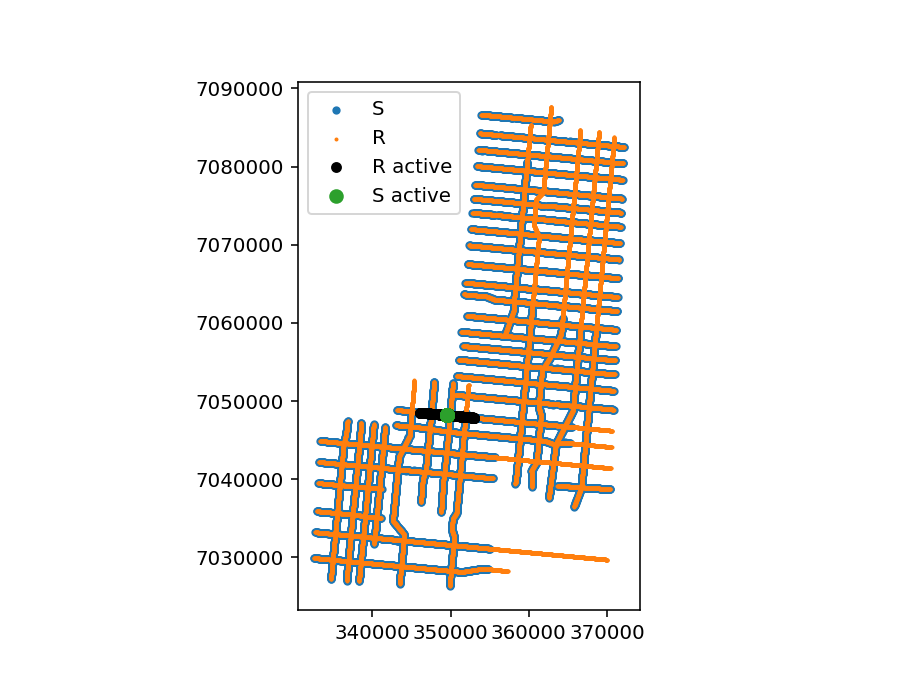

In [7]:
%matplotlib notebook

plt.scatter(dfs['x'], dfs['y'], s=10, label="S")
plt.scatter(dfr['x'], dfr['y'], s=1, label="R")

view = shot_batch.index._idf.loc[shot_batch.indices[125]]
plt.scatter(view['x_r'], view['y_r'], s=20, c='black', label="R active")
plt.scatter(view['x_s'], view['y_s'], s=40, label="S active")

plt.legend()
plt.axes().set_aspect('equal')
plt.show()

## Генерация батчей ОСТ сейсмограмм

In [8]:
origin = np.array([ 332509.32, 7015372.82])
phi = 20
bin_size = 10000

mp_index = FieldIndex(dfr=dfr, dfs=dfs, dfx=dfx, origin=origin, phi=phi, bin_size=bin_size)

In [9]:
fset = Dataset(mp_index, SeismicBatch)

In [10]:
batch = fset.next_batch(5)

In [11]:
batch.indices

Index(['1/1', '1/2', '1/3', '2/1', '2/2'], dtype='object')

<IPython.core.display.Javascript object>


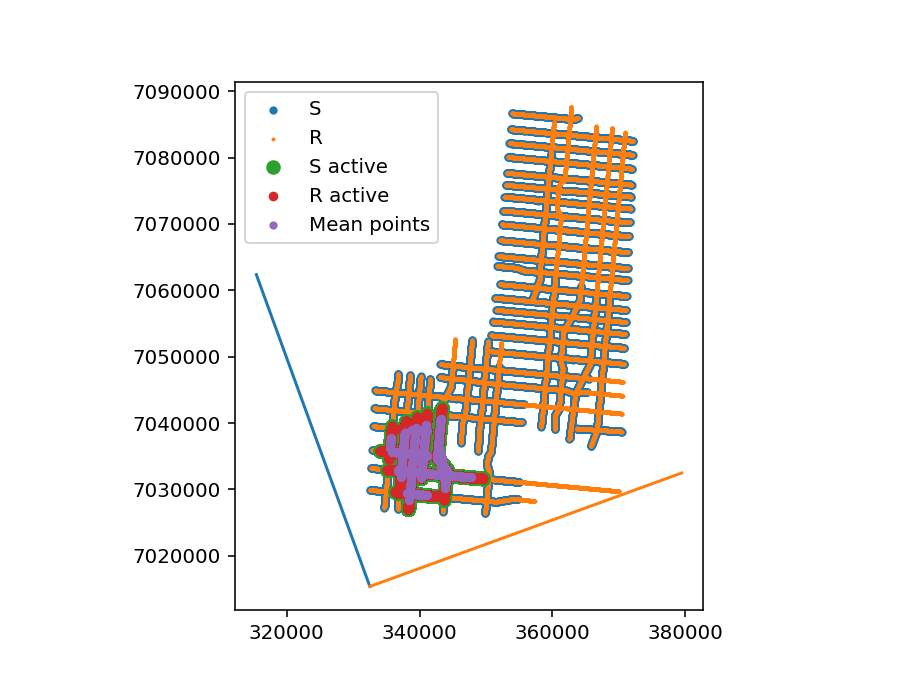

In [12]:
%matplotlib notebook

plt.scatter(dfs['x'], dfs['y'], s=10, label="S")
plt.scatter(dfr['x'], dfr['y'], s=1, label="R")

view = batch.index._idf.loc[batch.indices[4]]
plt.scatter(view['x_s'], view['y_s'], s=40, label="S active")
plt.scatter(view['x_r'], view['y_r'], s=15, label="R active")
plt.scatter(view['x_m'], view['y_m'], s=10, label="Mean points")

l = 50000
vecs = np.array([[0, l], [l, 0]])
rphi = phi * np.pi / 180
rotm = np.array([[np.cos(rphi), -np.sin(rphi)], [np.sin(rphi), np.cos(rphi)]])
vecs = origin + np.dot(rotm, vecs.T).T

plt.plot([origin[0], vecs[0, 0]], [origin[1], vecs[0, 1]])
plt.plot([origin[0], vecs[1, 0]], [origin[1], vecs[1, 1]])

plt.legend()
plt.axes().set_aspect('equal')
plt.show()

## Загрузка ОСТ сеймограмм

In [28]:
fset = Dataset(mp_index, SeismicBatch)

In [26]:
mp_index._idf.index.levels[0]

Index(['1/1', '1/2', '1/3', '2/1', '2/2', '2/3', '3/1', '3/2', '3/3', '4/1',
       '4/2', '4/3', '4/4', '4/5', '5/1', '5/2', '5/3', '5/4', '5/5', '5/6',
       '6/3', '6/4', '6/5', '6/6', '7/5'],
      dtype='object')

In [32]:
fset.next_batch(5).index._idf.index.levels[0]

Index(['1/1', '1/2', '1/3', '2/1', '2/2', '2/3', '3/1', '3/2', '3/3', '4/1',
       '4/2', '4/3', '4/4', '4/5', '5/1', '5/2', '5/3', '5/4', '5/5', '5/6',
       '6/3', '6/4', '6/5', '6/6', '7/5'],
      dtype='object')

In [30]:
batch.index._idf.index.levels[0]

Index(['1/1', '1/2', '1/3', '2/1', '2/2', '2/3', '3/1', '3/2', '3/3', '4/1',
       '4/2', '4/3', '4/4', '4/5', '5/1', '5/2', '5/3', '5/4', '5/5', '5/6',
       '6/3', '6/4', '6/5', '6/6', '7/5'],
      dtype='object')

In [29]:
path = '/home/egor/Desktop/2D_Valyton/prof_37/segy/'
batch = (fset.next_batch(5)
        .load(path=path, fmt='segy', get_file_by_index=get_file_by_index)
        .to_2d())

<IPython.core.display.Javascript object>


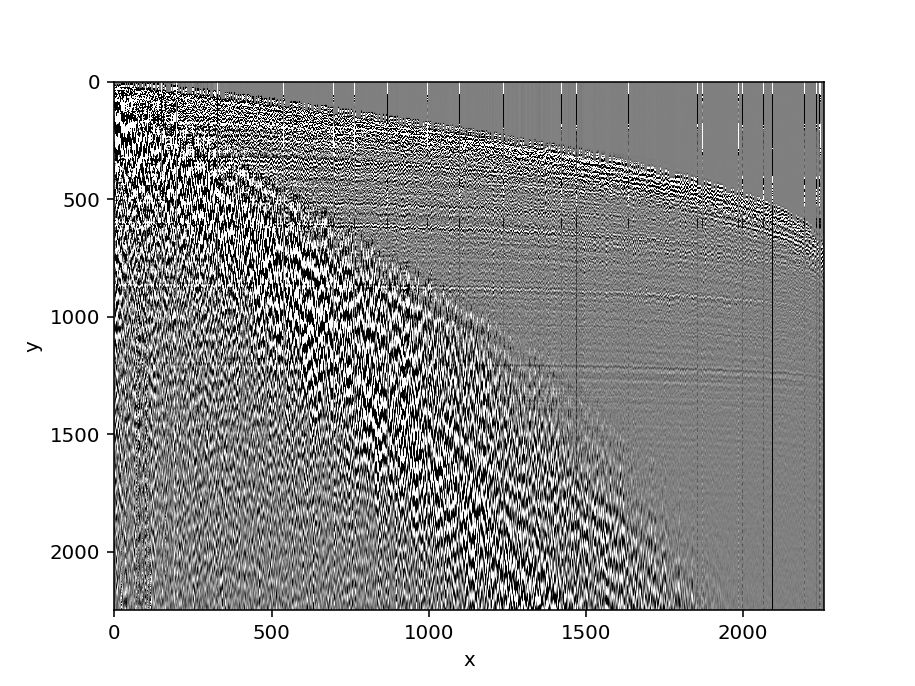

In [19]:
%matplotlib notebook
cv = 3
batch.show_slice(batch.indices[0], vmin=-cv, vmax=cv, cmap="gray")